In [ ]:
import pandas as pd
import numpy as np

# load census data
census = pd.read_csv("https://raw.githubusercontent.com/um-dsp/CIS545/main/adult-with-pii.csv")
census.columns

In [ ]:
census.head()

Differential privacy is typically used to answer specific queries.
Let's consider a query on the census data, without differential privacy.

**Example**: how many people are older than 50 years?


In [ ]:
result = census[census['Age'] >50].shape[0]
result



# Laplace Mechanism
For a function $f(d)$ which returns a number, the following definition of $M(d)$ satisfies $\epsilon$-differential privacy:
$$\begin{align}
M(d) = f(d) + \textsf{Lap}(\frac{s}{\epsilon})
\end{align}$$
where $s$ is the sensitivity of $f$, and $\textsf{Lap}(S)$ denotes sampling from the Laplace distribution with center 0 and scale $S = \frac{s}{\epsilon}$.

The sensitivity of a function $f$ is the maximum amount $f$'s output changes when its input changes by 1 record. Counting queries always have a sensitivity of 1.

In [ ]:
sensitivity = 1
epsilons = [0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 1]
for e in epsilons:
  print(e, result + np.random.laplace(loc=0, scale=sensitivity/e))

# Gauss Mechanism
For a function $f(d)$ which returns a number, the following definition of $M(d)$ satisfies ($\epsilon$,$\delta$)-differential privacy:

$$\begin{align}
M(d) = f(d) + \frac{s*\sqrt{2*\log{\frac{1.25}{\delta}}}}{\epsilon}
\end{align}$$
where $\delta$ is the "failure probability".

In [ ]:
1/census.shape[0]

3.071158748195694e-05

In [ ]:
sensitivity = 1
epsilon = 0.8
delta =3e-6 # <<1/census.shape[0]
result +np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

You can see the effect of the noise by running the avove cell multiple times. Each time, the output changes, but most of the time, the answer is close enough to the true answer (6460) to be useful.

# How much Noise is Enough Noise?

How do we know that the Laplace mechanism adds enough noise to prevent the re-identification of individuals in the dataset? For one thing, we can try to break it! Let's write down a malicious counting query, which is specifically designed to determine whether Amelia Madison has an income greater than \$50k.

In [ ]:
Amelia_row = census[census['Name'] == 'Amelia Madison']
Amelia_row[Amelia_row['Target'] == '<=50K'].shape[0]

This result definitely violates Amelia's privacy, since it reveals the value of the income column for Amelia's row. Since we know how to ensure differential privacy for counting queries with the Laplace mechanism, we can do so for this query:

In [ ]:
sensitivity = 1
epsilon = 0.3

Amelia_row = census[census['Name'] == 'Amelia Madison']
Amelia_row[Amelia_row['Target'] == '<=50K'].shape[0] + np.random.laplace(loc=0, scale=sensitivity/epsilon)

There's too much noise to be able to reliably tell the true value. This is how differential privacy is intended to work - the approach does not reject queries which are determined to be malicious; instead, it adds enough noise that the results of a malicious query will be useless ( at least confusing) to the adversary.

# Properties of Differential Privacy

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# example epsilon values
epsilon1 = 0.5
epsilon2 = 0.5
epsilon_total = epsilon1+epsilon2
r = result # 6460

In [ ]:
# satisfies 0.5-DP
def f1():
    return r+ np.random.laplace(loc=0, scale=1/epsilon1)

# satisfies 0.5-DP
def f2():
    return r+ np.random.laplace(loc=0, scale=1.0/epsilon2)

# satisfies 1-DP
def f3():
    return r+ np.random.laplace(loc=0, scale=1/epsilon_total)

# satisfies 1-DP, by sequential composition
def f_composite():
    return (f1() + f2()) / 2

# Sequential Composition

In [ ]:
# plotting f1 and f2

# plot f1
plt.hist([f1() for i in range(2000)], bins=50, label='f1');

# plot f2 (needs to be close to f1)
plt.hist([f2() for i in range(2000)], bins=50, alpha=.65, label='f2');
plt.legend()

As can be seen above f1 and f2 have similar distributions

In [ ]:
# plotting f1 and f3

# plot f1
plt.hist([f1() for i in range(1000)], bins=50, label='f1');

# plot f3
plt.hist([f3() for i in range(1000)], bins=50, alpha=.6, label='f3');
plt.legend()

We see in the plot above: f3 is much pointy than f1 due to its higher $\epsilon$ value, which implies less privacy (result is pretty close to true answer, i.e., 6460).

In [ ]:
# plotting f1 and f_composite

# plot f1
plt.hist([f1() for i in range(1000)], bins=50, label='f1');

# plot f_composite
plt.hist([f_composite() for i in range(1000)], bins=50, alpha=.75, label='f_composite');
plt.legend()

In [ ]:
# plotting f2 and f_composite

# plot f2
plt.hist([f2() for i in range(1000)], bins=50, label='f2');

# plot f_composite
plt.hist([f_composite() for i in range(1000)], bins=50, alpha=.75, label='f_composite');
plt.legend()

Distribution f_composite is more pointy -- meaning its outputs are more accurate than f1's/f2's outpts (reason: f_composite's $\epsilon$ is higher, hence it yields less privacy than f1/f2).

In [ ]:
# plotting f3 and f_composite

# plot f3
plt.hist([f3() for i in range(1000)], bins=50, label='f3');

# plot f_composite
plt.hist([f_composite() for i in range(1000)], bins=50, alpha=.75, label='f_composite');
plt.legend()

**Note**: $\epsilon$ value for f3 and f_composite is $\epsilon$ = 1. Hence, their output distributions should be close.

# Parallel Composition

To simulate a chunk, let's consider a histogram (splits the dataset into "bins" based on the value of one of the attributes, and counts the number of rows in each bin).

**Example**: count the number of people for each educational level.

In [ ]:
census['Education'].value_counts()

**Note**: Each bin (educational level): automatically satisfies parallel composition (reason: it's impossible for a single row to have two values for an attribute simultaneously, hence disjoint bins).

Now, let's use a differentially private mechanism to release all of the bin counts with a total privacy cost of just $\epsilon$ (as discussed in the lecture):

In [ ]:
epsilon = .5

# total privacy cost = .9, even though we release 16 chunks!
census['Education'].value_counts().apply(lambda x: x + np.random.laplace(loc=0, scale=1/epsilon))

Crosstabs (multi-dimensional histograms) used to analyze relationships between two attributes.

**Example**: Let's consider a crosstab that summarizes education level based on gender


In [ ]:
pd.crosstab(census['Education'], census['Sex'])

**Note**: as in the histogram we saw earlier, each individual in the dataset participates in exactly one count appearing in this table (hence, it's safe to use parallel composition)

In [ ]:
epsilon = 1
edu_gender = pd.crosstab(census['Education'], census['Sex'])
edu_gender.applymap(lambda x: x + np.random.laplace(loc=0, scale=1/epsilon))

**Question**: what happens if we keep adding other attributes to the crostab? For example, I add one more axis (say relationship) to the above analysis. Reason about implications on privacy and utility.

**Answer**: the values will gradually decrease and data becomes less useful (spontaneous degradation in utility).

# Post-Processing

Based on the above differentially private output after parallel composition, suppose we would like to round each result to the nearest integer.

**Question**: why is this a plausible post-processing and what are the risks here?

**Answer**: plausible because we are counting persons; risky because the rounding might reveal true outputs.

In [ ]:
edu_gender.applymap(lambda x: round(x + np.random.laplace(loc=0, scale=1/epsilon)))

# More on sensitivity

**Counting Queries**

**Example 1**: how many people are in the census dataset?

Sensitivity = 1

In [ ]:
census.shape[0]+np.random.laplace(loc=0, scale=1/0.2)

**Example 2**: how many people have an educational status above 10?
    
Sesitivity = 1

In [ ]:
census[census['Education-Num']>10].shape[0]

In [ ]:
census[census['Education-Num']>10].shape[0]+np.random.laplace(loc=0, scale=1/0.2)

**Example 3**: how many people are named Birhanu Eshete?

Sensitivity = 1

In [ ]:
census[census['Name']=='Birhanu Eshete'].shape[0]

In [ ]:
census[census['Name']=='Birhanu Eshete'].shape[0]+ np.random.laplace(loc=0, scale=1/0.2)

**Summation Queries**

**Example 4**: what is the sum of the ages of people with educational status below 10?

Sensitivity = ?

In [ ]:
census[census['Education-Num']<10]['Age'].sum()

In [ ]:
census[census['Education-Num']<10]['Age'].sum() + np.random.laplace(loc=0, scale=125/0.5)

**Note**: Sensitivity is not as straight forward as counting queries. Adding a new row to census will increase the sum by the age of the new record (sensitivity depends on the content of the row we add, 125 perhaps?).

**Rule of thumb**: summation queries have unbounded sensitivity when no \[lower,upper\] exist for the attribute being summed. When \[lower, upper\] exists, sensitivity = \|upper -  lower\|.

**Average Queries**

**Example 5**: what is the average age of people with educational status below 10?

Sensitivity = ?

In [ ]:
census[census['Education-Num']<10]['Age'].mean()

**Question**: how do we answer the above query with differential privacy? (Hint: split the query)

In [ ]:
sensitivity_sum = 125
epsilon = 0.01
dp_sum = census[census['Education-Num']<10]['Age'].sum() + np.random.laplace(loc=0, scale=sensitivity_sum/epsilon)
print('DP-Sum:', dp_sum)
sensitivity_cnt = 1
dp_count = census[census['Education-Num']<10]['Age'].shape[0] +np.random.laplace(loc=0, scale=sensitivity_cnt/epsilon)
print ('DP-Count:',dp_count)
dp_mean = dp_sum/dp_count
print ('DP-Mean',round(dp_mean))

# Clipping

Queries with unbounded sensitivity cannot be directly answered with differential privacy using noise. We can transform such queries to equivalent queries with bounded sensitivity, through a process called *clipping*.

**Example**: consider age and we would like to clip age to \[0,125\]. The rationale being: a) oldest age recorded is 125, b) newborns may be in the dataset.

In [ ]:
census['Age'].sum()

In [ ]:
census['Age'].clip(lower=20,upper=125).sum()

**Question**: What is the sensitivity for the above query?

**Note**: clipping for attributes such as age is relatively simple. However, for other attributes (e.g., salary) it happens to be hard.

**Rule of thumb**: try to set the clipping bounds to include the whole dataset (as close as possible).

**Finding clipping clues by looking at the data**

In [ ]:
plt.hist(census['Age'])

In [ ]:
plt.hist(census['fnlwgt'])

(array([  219.,   333.,  1160.,   933.,  1608., 10501.,  8673.,  1067.,
         7078.,   989.]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 <a list of 10 Patch objects>)

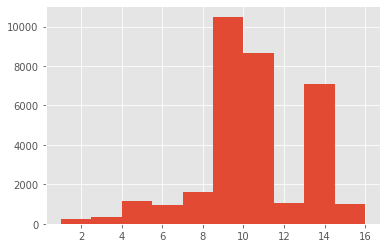

In [ ]:
plt.hist(census['Education-Num'])

In [ ]:
plt.hist(census['Hours per week'])

**Question**: is determining the clipping bounds this way inline with differential privacy?

**Answer**: not necessarily, because if we clip based on the bounds found directly from the dataset, we might end up releasing crucial clues about the values of an attribue.